## Setup Environments

### Mount Drive and Setup Project Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_dir="your-project-directory"

In [3]:
project_dir="/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements"

In [4]:
%cd {project_dir}

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [6]:
# GPU Check
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "")

Using device: cuda (NVIDIA A100-SXM4-40GB)


In [7]:
!nvidia-smi

Sun May 25 01:55:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## CIFAR10 Dataset

In [8]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [9]:
# Create transform to resize and normalize image for training
transform = transforms.Compose([
    transforms.Resize((227, 227)), # Resize ให้ตรงกับ AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), # Normalize ตาม standard CIFAR-10
                         (0.5, 0.5, 0.5))
])

In [10]:
# Download CIFAR-10 Dataset
data_path = "./data"
full_train_set = CIFAR10(root=data_path, train=True, download=True, transform=transform)
test_set = CIFAR10(root=data_path, train=False, download=True, transform=transform)

In [11]:
# Split 85% Train / 10% Val / 5% Eval
total_len = len(full_train_set)
train_len = int(0.85 * total_len)
val_len = int(0.10 * total_len)
eval_len = total_len - train_len - val_len

train_set, val_set, eval_set = random_split(full_train_set, [train_len, val_len, eval_len])

In [12]:
print(f"Dataset Split:\n - Train: {len(train_set)}\n - Val: {len(val_set)}\n - Eval: {len(eval_set)}\n - Test: {len(test_set)}")

Dataset Split:
 - Train: 42500
 - Val: 5000
 - Eval: 2500
 - Test: 10000


### Display CIFAR-10 Dataset

In [13]:
import matplotlib.pyplot as plt

# Label names of CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
# ฟังก์ชันแสดง Before/After โดยใช้ภาพเดียวกันจริง ๆ
def show_cifar10_before_after_aligned(num_images=6):
    # โหลด dataset ดิบ (Before)
    original_dataset = CIFAR10(root="./data", train=True, download=False, transform=transforms.ToTensor())

    # โหลด dataset ที่ถูก transform แล้ว (After)
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])
    transformed_dataset = CIFAR10(root="./data", train=True, download=False, transform=transform)

    # สุ่ม index เดียวกัน
    indices = random.sample(range(len(original_dataset)), num_images)

    plt.figure(figsize=(num_images * 2.5, 5))

    for i, idx in enumerate(indices):
        orig_img, orig_label = original_dataset[idx]
        trans_img, trans_label = transformed_dataset[idx]

        # แปลงกลับจาก Normalize
        mean = torch.tensor([0.5, 0.5, 0.5]).reshape(3, 1, 1)
        std = torch.tensor([0.5, 0.5, 0.5]).reshape(3, 1, 1)
        trans_img = trans_img * std + mean

        # Plot Before
        plt.subplot(2, num_images, i + 1)
        plt.imshow(orig_img.permute(1, 2, 0).numpy())
        plt.title(f"Before\n{class_names[orig_label]}")
        plt.axis("off")

        # Plot After
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(trans_img.permute(1, 2, 0).numpy())
        plt.title(f"After\n{class_names[trans_label]}")
        plt.axis("off")

    plt.suptitle("CIFAR-10: Before vs After Transform", fontsize=16)
    plt.tight_layout()
    plt.show()

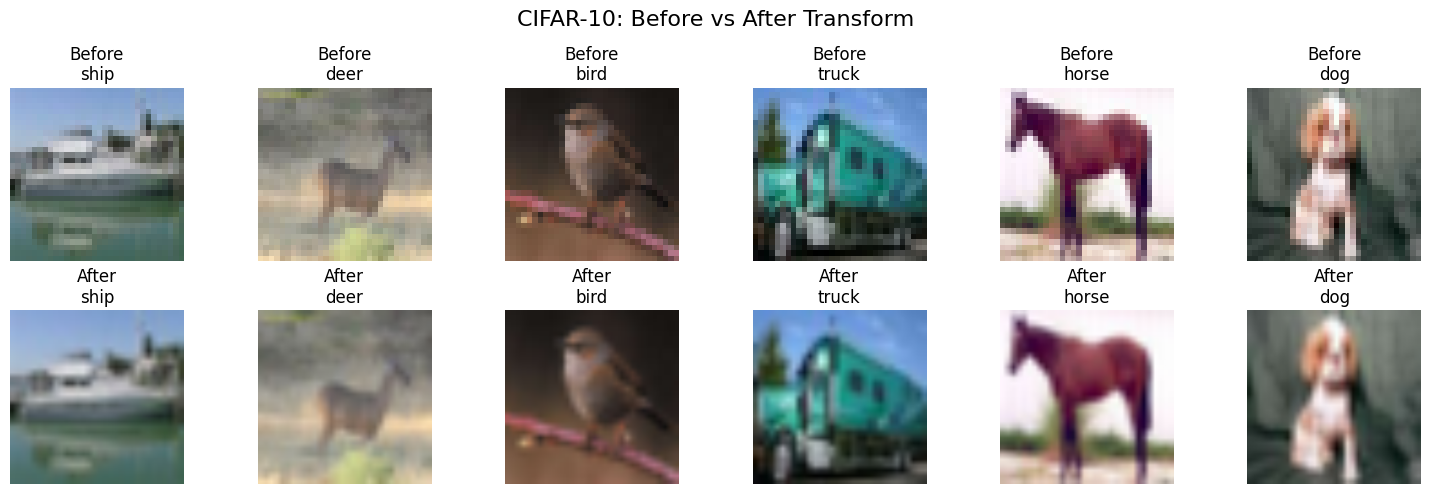

In [15]:
show_cifar10_before_after_aligned(num_images=6)

### Data Loader

In [16]:
# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
eval_loader = DataLoader(eval_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Define AlexNet

In [17]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):  # CIFAR-10 มี 10 คลาส
        super(AlexNet, self).__init__()

        # Feature Extractor (Backbone)
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),  # input: (3, 227, 227) → output: (96, 55, 55)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # → (96, 27, 27)

            nn.Conv2d(96, 256, kernel_size=5, padding=2),           # → (256, 27, 27)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # → (256, 13, 13)

            nn.Conv2d(256, 384, kernel_size=3, padding=1),          # → (384, 13, 13)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),          # → (384, 13, 13)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # → (256, 13, 13)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)                   # → (256, 6, 6)
        )

        # Classifier (Fully Connected)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # flatten from (B, 256, 6, 6) → (B, 9216)
        x = self.classifier(x)
        return x

In [18]:
# Create a Model and move to GPU
model = AlexNet().to(device) # move to GPU

#### Model Summary

In [19]:
!pip install -q torchsummary

In [20]:
from torchsummary import summary
summary(model, input_size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

###  Visualize Feature Maps (Convolution Layer)

In [21]:
def visualize_feature_maps_with_input(model, data_loader, device, num_channels=8):
    model.eval()

    # เอาภาพตัวอย่างจาก DataLoader
    images, labels = next(iter(data_loader))
    image = images[0].unsqueeze(0).to(device)  # เอาภาพเดียว

    # แสดงภาพต้นฉบับ (หลัง transform แล้ว)
    unnorm = lambda x: x * 0.5 + 0.5
    input_img = unnorm(images[0]).permute(1, 2, 0).numpy()

    plt.figure(figsize=(3, 3))
    plt.imshow(np.clip(input_img, 0, 1))
    plt.title("🔹 Input Image (Resized + Normalized)")
    plt.axis('off')
    plt.show()

    # ส่งภาพผ่านแต่ละชั้น
    x = image
    for idx, layer in enumerate(model.features):
        x = layer(x)

        if isinstance(layer, nn.Conv2d):
            print(f"Layer {idx}: {layer.__class__.__name__} → Shape: {x.shape}")

            fmap = x.detach().cpu().squeeze(0)  # Shape: (C, H, W)

            plt.figure(figsize=(15, 3))
            for i in range(min(num_channels, fmap.shape[0])):
                plt.subplot(1, num_channels, i + 1)
                plt.imshow(fmap[i], cmap='viridis')
                plt.title(f"Channel {i}")
                plt.axis('off')

            plt.suptitle(f"Feature Map after Conv Layer {idx}", fontsize=14)
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


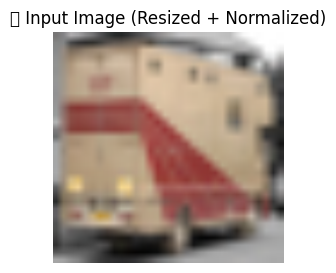

Layer 0: Conv2d → Shape: torch.Size([1, 96, 55, 55])


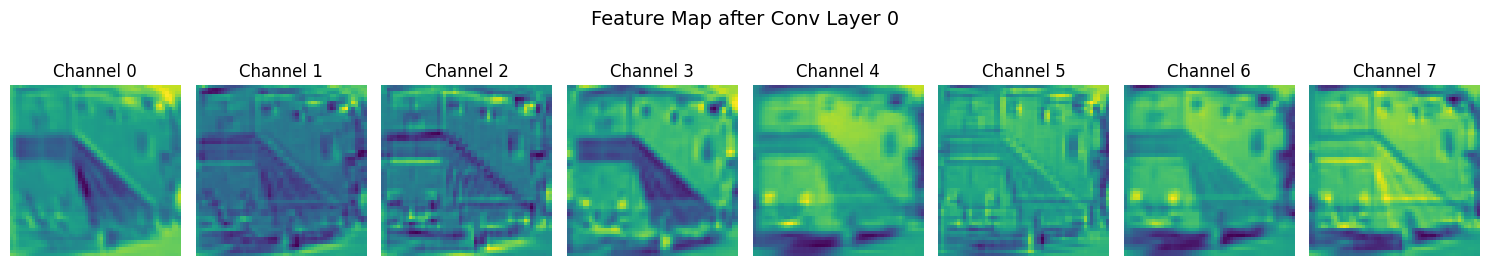

Layer 3: Conv2d → Shape: torch.Size([1, 256, 27, 27])


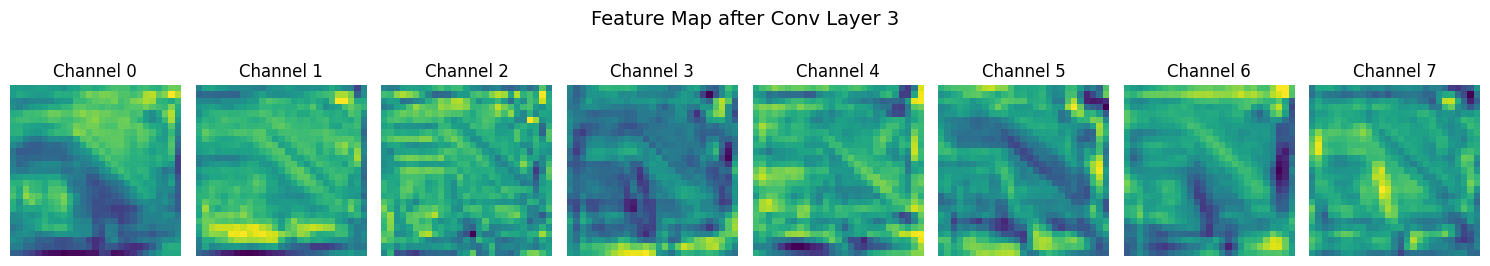

Layer 6: Conv2d → Shape: torch.Size([1, 384, 13, 13])


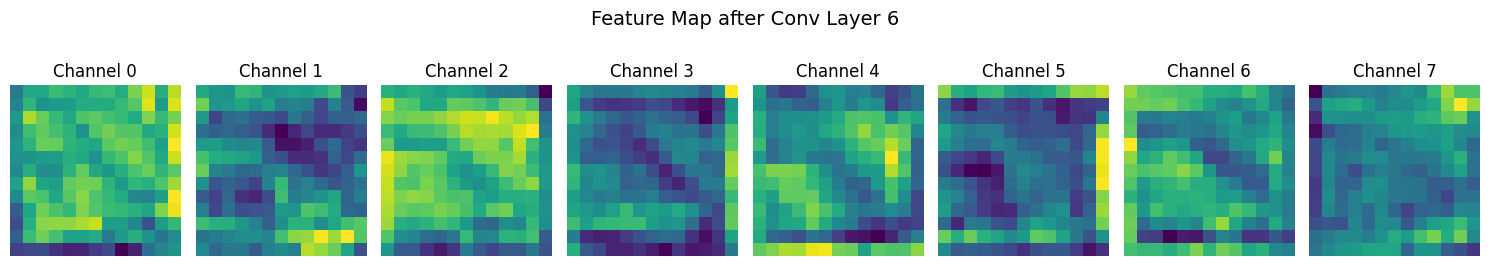

Layer 8: Conv2d → Shape: torch.Size([1, 384, 13, 13])


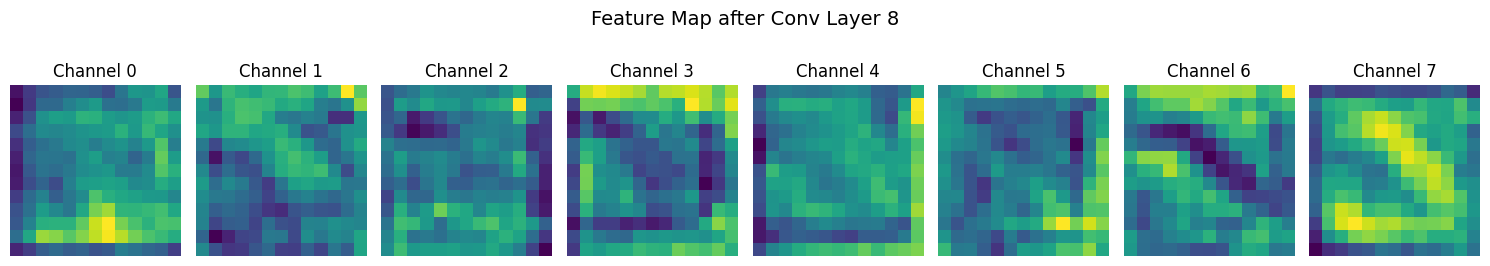

Layer 10: Conv2d → Shape: torch.Size([1, 256, 13, 13])


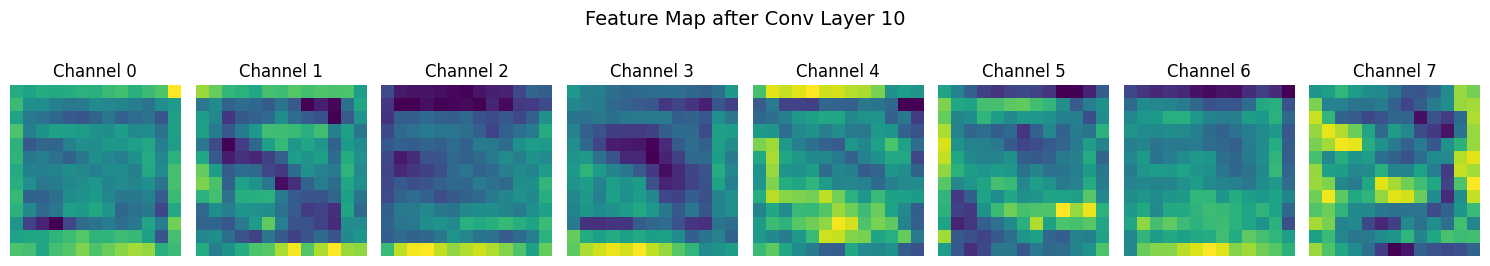

In [22]:
visualize_feature_maps_with_input(model, train_loader, device)

## Training Loop

In [23]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

In [24]:
# Training Params
EPOCHS = 50
LR = 0.001

```
CrossEntropy = -log(softmax(predicted_class_score))
```

In [25]:
# Set up training params
criterion = nn.CrossEntropyLoss() # Loss function for Multi-Class Classification
optimizer = optim.Adam(model.parameters(), lr=LR) # Adam Optimizer

In [26]:
# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [27]:
# EarlyStopping config
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

In [28]:
start_time = time.time()

for epoch in range(EPOCHS):

    # Training Loop
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation Loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

    # 💡 EarlyStopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"Training Completed in {total_time:.2f} seconds.")


Epoch 1/50: 100%|██████████| 665/665 [00:36<00:00, 18.02it/s, acc=33.4, loss=1.13]



Epoch 1 - Train Loss: 1.7903, Train Acc: 33.41% | Val Loss: 1.5079, Val Acc: 42.80%



Epoch 2/50: 100%|██████████| 665/665 [00:36<00:00, 18.38it/s, acc=46.4, loss=1.96]



Epoch 2 - Train Loss: 1.4700, Train Acc: 46.36% | Val Loss: 1.3708, Val Acc: 50.10%



Epoch 3/50: 100%|██████████| 665/665 [00:36<00:00, 18.32it/s, acc=51.1, loss=0.318]



Epoch 3 - Train Loss: 1.3442, Train Acc: 51.14% | Val Loss: 1.2862, Val Acc: 54.20%



Epoch 4/50: 100%|██████████| 665/665 [00:36<00:00, 18.35it/s, acc=55.1, loss=1.29]



Epoch 4 - Train Loss: 1.2521, Train Acc: 55.07% | Val Loss: 1.1753, Val Acc: 58.30%



Epoch 5/50: 100%|██████████| 665/665 [00:36<00:00, 18.32it/s, acc=57.6, loss=1.1]



Epoch 5 - Train Loss: 1.1821, Train Acc: 57.61% | Val Loss: 1.1905, Val Acc: 56.50%

No improvement for 1 epochs


Epoch 6/50: 100%|██████████| 665/665 [00:36<00:00, 18.38it/s, acc=60, loss=0.393]



Epoch 6 - Train Loss: 1.1227, Train Acc: 60.04% | Val Loss: 1.1251, Val Acc: 59.80%



Epoch 7/50: 100%|██████████| 665/665 [00:36<00:00, 18.40it/s, acc=62.1, loss=1.35]



Epoch 7 - Train Loss: 1.0669, Train Acc: 62.08% | Val Loss: 1.0750, Val Acc: 62.94%



Epoch 8/50: 100%|██████████| 665/665 [00:36<00:00, 18.45it/s, acc=63.7, loss=1.57]



Epoch 8 - Train Loss: 1.0227, Train Acc: 63.68% | Val Loss: 1.0578, Val Acc: 62.30%



Epoch 9/50: 100%|██████████| 665/665 [00:35<00:00, 18.47it/s, acc=65, loss=1.04]



Epoch 9 - Train Loss: 0.9930, Train Acc: 65.00% | Val Loss: 1.0481, Val Acc: 62.70%



Epoch 10/50: 100%|██████████| 665/665 [00:36<00:00, 18.41it/s, acc=66.1, loss=2.85]



Epoch 10 - Train Loss: 0.9570, Train Acc: 66.12% | Val Loss: 1.0171, Val Acc: 64.82%



Epoch 11/50: 100%|██████████| 665/665 [00:36<00:00, 18.26it/s, acc=66.7, loss=0.344]



Epoch 11 - Train Loss: 0.9392, Train Acc: 66.73% | Val Loss: 1.0187, Val Acc: 64.42%

No improvement for 1 epochs


Epoch 12/50: 100%|██████████| 665/665 [00:36<00:00, 18.28it/s, acc=68.4, loss=1.18]



Epoch 12 - Train Loss: 0.8911, Train Acc: 68.44% | Val Loss: 1.0041, Val Acc: 65.42%



Epoch 13/50: 100%|██████████| 665/665 [00:36<00:00, 18.40it/s, acc=69.1, loss=0.655]



Epoch 13 - Train Loss: 0.8704, Train Acc: 69.11% | Val Loss: 0.9622, Val Acc: 66.76%



Epoch 14/50: 100%|██████████| 665/665 [00:36<00:00, 18.30it/s, acc=70.1, loss=1.18]



Epoch 14 - Train Loss: 0.8457, Train Acc: 70.06% | Val Loss: 0.9620, Val Acc: 67.10%



Epoch 15/50: 100%|██████████| 665/665 [00:36<00:00, 18.36it/s, acc=70.9, loss=0.625]



Epoch 15 - Train Loss: 0.8187, Train Acc: 70.92% | Val Loss: 0.9633, Val Acc: 66.82%

No improvement for 1 epochs


Epoch 16/50: 100%|██████████| 665/665 [00:36<00:00, 18.46it/s, acc=72.2, loss=1.43]



Epoch 16 - Train Loss: 0.7940, Train Acc: 72.17% | Val Loss: 0.9370, Val Acc: 68.28%



Epoch 17/50: 100%|██████████| 665/665 [00:36<00:00, 18.39it/s, acc=72.6, loss=1.28]



Epoch 17 - Train Loss: 0.7737, Train Acc: 72.60% | Val Loss: 0.9761, Val Acc: 66.56%

No improvement for 1 epochs


Epoch 18/50: 100%|██████████| 665/665 [00:36<00:00, 18.44it/s, acc=73.2, loss=0.854]



Epoch 18 - Train Loss: 0.7539, Train Acc: 73.24% | Val Loss: 0.9422, Val Acc: 67.36%

No improvement for 2 epochs


Epoch 19/50: 100%|██████████| 665/665 [00:36<00:00, 18.43it/s, acc=74.4, loss=0.808]



Epoch 19 - Train Loss: 0.7333, Train Acc: 74.45% | Val Loss: 0.9346, Val Acc: 68.48%



Epoch 20/50: 100%|██████████| 665/665 [00:36<00:00, 18.28it/s, acc=75.5, loss=1.32]



Epoch 20 - Train Loss: 0.6973, Train Acc: 75.48% | Val Loss: 0.9886, Val Acc: 66.72%

No improvement for 1 epochs


Epoch 21/50: 100%|██████████| 665/665 [00:35<00:00, 18.54it/s, acc=74.7, loss=0.552]



Epoch 21 - Train Loss: 0.7190, Train Acc: 74.71% | Val Loss: 0.9403, Val Acc: 68.54%

No improvement for 2 epochs


Epoch 22/50: 100%|██████████| 665/665 [00:36<00:00, 18.42it/s, acc=76.2, loss=0.708]



Epoch 22 - Train Loss: 0.6788, Train Acc: 76.18% | Val Loss: 0.9366, Val Acc: 69.06%

No improvement for 3 epochs


Epoch 23/50: 100%|██████████| 665/665 [00:36<00:00, 18.20it/s, acc=76.5, loss=0.349]



Epoch 23 - Train Loss: 0.6656, Train Acc: 76.52% | Val Loss: 0.9314, Val Acc: 68.04%



Epoch 24/50: 100%|██████████| 665/665 [00:36<00:00, 18.32it/s, acc=77.9, loss=1.12]



Epoch 24 - Train Loss: 0.6286, Train Acc: 77.91% | Val Loss: 0.9194, Val Acc: 69.40%



Epoch 25/50: 100%|██████████| 665/665 [00:36<00:00, 18.23it/s, acc=78.6, loss=0.566]



Epoch 25 - Train Loss: 0.6142, Train Acc: 78.59% | Val Loss: 0.9434, Val Acc: 68.00%

No improvement for 1 epochs


Epoch 26/50: 100%|██████████| 665/665 [00:36<00:00, 18.41it/s, acc=78.8, loss=0.654]



Epoch 26 - Train Loss: 0.6036, Train Acc: 78.79% | Val Loss: 0.9346, Val Acc: 69.24%

No improvement for 2 epochs


Epoch 27/50: 100%|██████████| 665/665 [00:36<00:00, 18.37it/s, acc=80.4, loss=0.612]



Epoch 27 - Train Loss: 0.5632, Train Acc: 80.44% | Val Loss: 0.9588, Val Acc: 68.80%

No improvement for 3 epochs


Epoch 28/50: 100%|██████████| 665/665 [00:36<00:00, 18.36it/s, acc=80.3, loss=1.12]



Epoch 28 - Train Loss: 0.5758, Train Acc: 80.30% | Val Loss: 0.9439, Val Acc: 69.38%

No improvement for 4 epochs


Epoch 29/50: 100%|██████████| 665/665 [00:36<00:00, 18.45it/s, acc=80.8, loss=0.239]



Epoch 29 - Train Loss: 0.5496, Train Acc: 80.84% | Val Loss: 0.9730, Val Acc: 69.56%

No improvement for 5 epochs
Early stopping triggered at epoch 29
Training Completed in 1197.76 seconds.


## Evaluate

 ### Plot Accuracy & Loss Graph

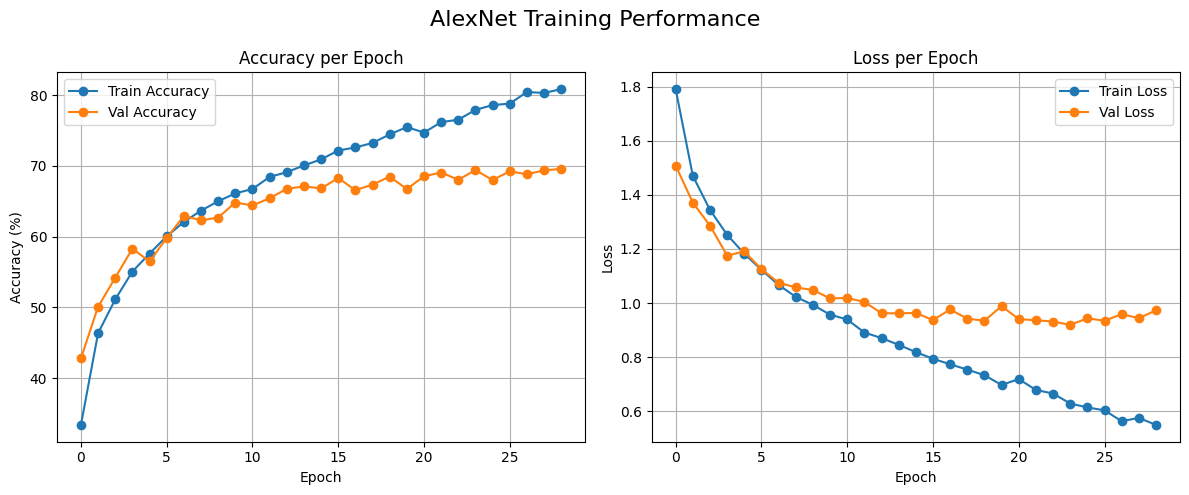

In [29]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("AlexNet Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

### Evaluation Metrics (Precision / Recall / F1-score)
> [วิธีอ่านค่า Evaluation Metrics (Confusion Matrix / Recall / Precision / F1-score)](https://github.com/morsetechlab/DeepVision-Classical-Models?tab=readme-ov-file#%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%AD%E0%B9%88%E0%B8%B2%E0%B8%99%E0%B8%84%E0%B9%88%E0%B8%B2-evaluation-metrics-precision--recall--f1-score)


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [31]:
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Evaluation on Eval Set:
Accuracy: 70.64%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.82      0.76       240
  automobile       0.81      0.81      0.81       251
        bird       0.72      0.52      0.60       259
         cat       0.50      0.53      0.52       251
        deer       0.65      0.67      0.66       229
         dog       0.60      0.64      0.62       250
        frog       0.76      0.71      0.73       266
       horse       0.81      0.71      0.75       241
        ship       0.75      0.84      0.79       257
       truck       0.78      0.82      0.80       256

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.70      2500
weighted avg       0.71      0.71      0.71      2500



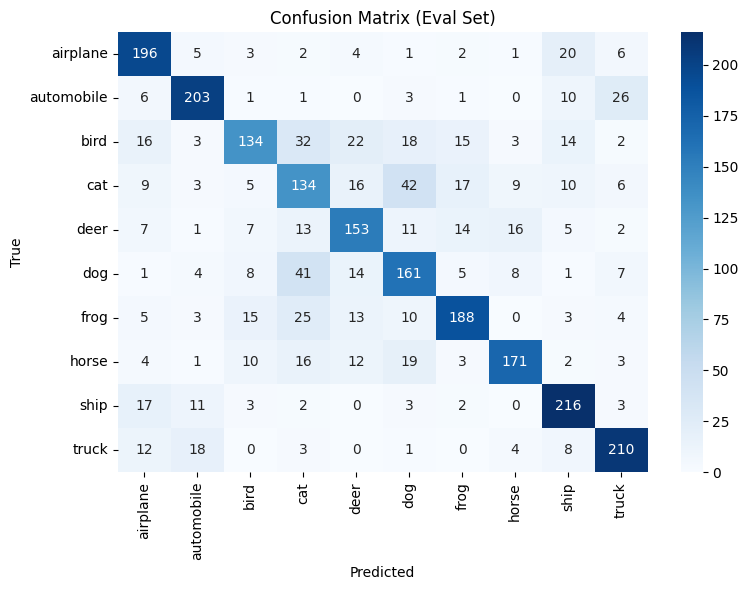

In [32]:
print("Evaluation on Eval Set:")
evaluate_model(model, eval_loader, class_names, title="Confusion Matrix (Eval Set)")

Evaluation on Test Set:
Accuracy: 69.44%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.78      0.74      1000
  automobile       0.83      0.83      0.83      1000
        bird       0.69      0.47      0.56      1000
         cat       0.48      0.54      0.51      1000
        deer       0.66      0.62      0.64      1000
         dog       0.58      0.61      0.59      1000
        frog       0.77      0.73      0.75      1000
       horse       0.79      0.74      0.77      1000
        ship       0.73      0.83      0.78      1000
       truck       0.73      0.79      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



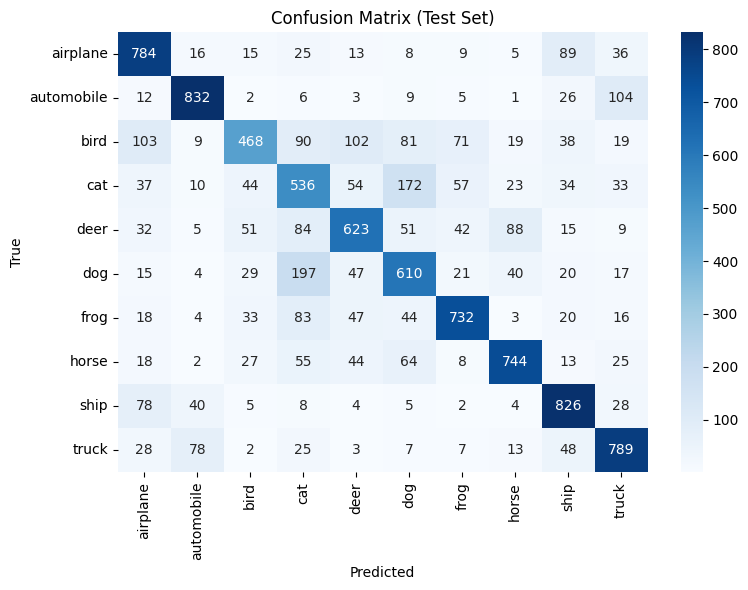

In [33]:
print("Evaluation on Test Set:")
evaluate_model(model, test_loader, class_names, title="Confusion Matrix (Test Set)")

## Random Inference

In [34]:
import random

def run_random_inference(model, data_loader, class_names, num_samples=5):
    model.eval()
    images, labels = next(iter(data_loader))

    # สุ่ม index
    idxs = random.sample(range(len(images)), num_samples)
    sampled_images = images[idxs]
    sampled_labels = labels[idxs]

    # ส่งเข้าโมเดล
    with torch.no_grad():
        outputs = model(sampled_images.to(device))
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()

    # แสดงผลลัพธ์
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        img = sampled_images[i]
        label = class_names[sampled_labels[i]]
        pred = class_names[preds[i]]
        correct = label == pred

        # แปลงภาพกลับจาก Normalize
        unnorm = lambda x: x * 0.5 + 0.5
        img = unnorm(img).permute(1, 2, 0).numpy()

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Pred: {pred}\nTrue: {label}", color='green' if correct else 'red')
        plt.axis('off')

    plt.suptitle("Random Inference from Test Set", fontsize=16)
    plt.tight_layout()
    plt.show()

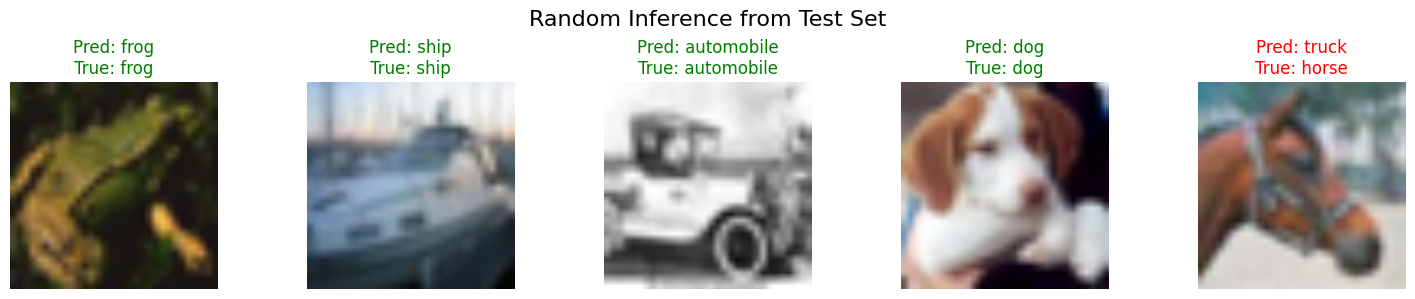

In [35]:
run_random_inference(model, test_loader, class_names)

## Export Model

In [36]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [37]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "alexnet_cifar10.pt")
torch.save(model.state_dict(), model_path)
print(f"Model Saved at {model_path}")

Model Saved at saved_models/alexnet_cifar10.pt


## Load Model

In [38]:
model = AlexNet(num_classes=10)
model.load_state_dict(torch.load(f"{project_dir}/saved_models/alexnet_cifar10.pt"))

<All keys matched successfully>